In [1]:
import numpy as np
from datetime import datetime

import torch
import torchvision

from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision.utils import save_image

In [2]:
batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# class Encoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(x_size, h_size)
#         self.mu_gen = nn.Linear(h_size, z_size)
#         # make the output to be the logarithm 
#         # i.e will have to take the exponent
#         # which forces variance to be positive
#         # not that this is the diagonal of the covariance
#         self.log_var_gen = nn.Linear(h_size, z_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         mu = self.mu_gen(x)
#         log_var = self.log_var_gen(x)
#         return mu, log_var
    
class Encoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim=10):

        super(Encoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        cnn_kwargs = dict(stride=2, padding=1)

        self.conv1 = nn.Conv2d(n_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        if self.img_size[1] == self.img_size[2] == 64:
            self.conv_64 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.lin1 = nn.Linear(np.product(self.reshape), hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)

        self.mu_logvar_gen = nn.Linear(hidden_dim, self.latent_dim * 2)

    def forward(self, x):
        batch_size = x.size(0)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.conv_64(x))

        x = x.view((batch_size, -1))
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))

        mu_logvar = self.mu_logvar_gen(x)

        mu, logvar = mu_logvar.view(-1, self.latent_dim, 2).unbind(-1)

        return mu, logvar

In [5]:
# class Decoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(z_size, h_size)
#         self.fc3 = nn.Linear(h_size, x_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc3(x))
#         # black and white MNIST => sigmoid for each pixel
#         x = torch.sigmoid(x) 
#         return x
    
class Decoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim):

        super(Decoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.img_size = img_size
        self.latent_dim = latent_dim

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        self.lin1 = nn.Linear(latent_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, np.product(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)

        if self.img_size[1] == self.img_size[2] == 64:
            self.convT_64 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.convT1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(hidden_channels, n_channels, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)

        x = torch.relu(self.lin1(z))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))

        x = x.view(batch_size, *self.reshape)

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.convT_64(x))

        x = torch.relu(self.convT1(x))
        x = torch.relu(self.convT2(x))

        x = torch.sigmoid(self.convT3(x))

        return x

In [6]:
# class VAE(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(VAE, self).__init__()
#         self.x_size = x_size
#         self.z_size = z_size
#         self.encoder = Encoder(x_size, h_size, z_size)
#         self.decoder = Decoder(x_size, h_size, z_size)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var) # square root in exponent => std
#         eps = torch.randn_like(std)
#         z = std * eps + mu
#         return z

#     def forward(self, x):
#         # make image linear (i.e vector form)
#         x = x.view(-1, self.x_size)
#         mu, log_var = self.encoder(x)
#         z = self.reparameterize(mu, log_var)
#         x_hat = self.decoder(z)
#         return x_hat, mu, log_var

class VAE(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(VAE, self).__init__()
        if list(img_size[1:]) not in [[32,32], [64,64]]:
            raise RuntimeError("{} sized images not supported. Only (None, 32, 32) and (None, 64, 64) supported. Build your own architecture or reshape images!".format(img_size))

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.num_pixels = self.img_size[1] * self.img_size[2]
        self.encoder = Encoder(img_size, self.latent_dim)
        self.decoder = Decoder(img_size, self.latent_dim)

        self.reset_parameters()

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + std * eps

        else:
            return mean


    def forward(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        reconstruct = self.decoder(latent_sample)
        return reconstruct, latent_distribution, latent_sample

    def reset_parameters(self):
        self.apply(weights_init)

    def sample_latent(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        return latent_sample

In [10]:
def get_activation_name(activation):
    """Given a string or a `torch.nn.modules.activation` return the name of the activation."""
    if isinstance(activation, str):
        return activation

    mapper = {nn.LeakyReLU: "leaky_relu", nn.ReLU: "relu", nn.Tanh: "tanh",
              nn.Sigmoid: "sigmoid", nn.Softmax: "sigmoid"}
    for k, v in mapper.items():
        if isinstance(activation, k):
            return k

    raise ValueError("Unkown given activation type : {}".format(activation))


def get_gain(activation):
    """Given an object of `torch.nn.modules.activation` or an activation name
    return the correct gain."""
    if activation is None:
        return 1

    activation_name = get_activation_name(activation)

    param = None if activation_name != "leaky_relu" else activation.negative_slope
    gain = nn.init.calculate_gain(activation_name, param)

    return gain
def linear_init(layer, activation="relu"):
    """Initialize a linear layer.
    Args:
        layer (nn.Linear): parameters to initialize.
        activation (`torch.nn.modules.activation` or str, optional) activation that
            will be used on the `layer`.
    """
    x = layer.weight

    if activation is None:
        return nn.init.xavier_uniform_(x)

    activation_name = get_activation_name(activation)

    if activation_name == "leaky_relu":
        a = 0 if isinstance(activation, str) else activation.negative_slope
        return nn.init.kaiming_uniform_(x, a=a, nonlinearity='leaky_relu')
    elif activation_name == "relu":
        return nn.init.kaiming_uniform_(x, nonlinearity='relu')
    elif activation_name in ["sigmoid", "tanh"]:
        return nn.init.xavier_uniform_(x, gain=get_gain(activation))
def weights_init(module):
    if isinstance(module, nn.modules.conv._ConvNd):
        # TO-DO: check litterature
        linear_init(module)
    elif isinstance(module, nn.Linear):
        linear_init(module)

In [13]:
def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed

def _kl_normal_loss(mean, logvar):
    latent_dim = mean.size(1)
    latent_kl = 0.5 * (-1 - logvar + mean.pow(2) + logvar.exp()).mean(dim=0)
    total_kl = latent_kl.sum()

    return total_kl

def _reconstruction_loss(data, recon_data, distribution="bernoulli"):
    batch_size, n_channels, height, width = recon_data.size()
    is_colored = n_channels == 3

    if distribution == "bernoulli":
        loss = F.binary_cross_entropy(recon_data, data, reduction="sum")

    elif distribution == "gaussian":
        loss = F.mse_loss(recon_data * 255, data * 255, reduction="sum") / 255

    elif distribution == "laplace":
        loss = F.l1_loss(recon_data, data, reduction="sum")
        loss = loss * 3
        loss = loss * (loss != 0)

    loss = loss / batch_size

    return loss

def loss_function(x_hat, x, mu, log_var, is_train, n_train_steps, steps_anneal=0, beta=1, C_init=0., C_fin=20., gamma=100.):
    """Compute the ELBO loss"""
    x_size = x_hat.size(-1)
    # black or white image => use sigmoid for each pixel
#     rec_loss = F.binary_cross_entropy(x_hat, x.view(-1, x_size), reduction='sum')
    rec_loss = _reconstruction_loss(x, x_hat, distribution="bernoulli")
    # closed form solution for gaussian prior and posterior
#     kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_div = _kl_normal_loss(mu, log_var)
    
    C = (linear_annealing(C_init, C_fin, n_train_steps, steps_anneal) if is_train else C_fin)
    vae_loss = rec_loss + gamma * (kl_div - C).abs()
#     vae_loss = rec_loss + beta * kl_div
    return vae_loss

In [14]:
class Trainer:
    def __init__(self, model, optimizer=optim.Adam, loss_function=loss_function):
        self.model = model 
        self.optimizer = optimizer(self.model.parameters())
        self.loss_function = loss_function
        self.epoch = 0
        
    def __call__(self, train, test, n_epochs=100):
        self.epoch = 0
        for _ in range(n_epochs):
            self._train_epoch(train)
            self._test_epoch(test)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           '../results/sample_' + str(self.epoch) + '.png')
        
    def _train_epoch(self, train):
        self.epoch += 1
        model.train() # make sure train mode (e.g. dropout)
        train_loss = 0
        for i, (x, _) in enumerate(train):
            x = x.to(device) # data on GPU 
            self.optimizer.zero_grad() # reset all previous gradients
            x_hat, latent_distribution, latent_sample = model(x)
            loss = self.loss_function(x_hat, x, *latent_distribution, True, i)
            loss.backward() # backpropagate (i.e store gradients)
            train_loss += loss.item() # compute loss (.item because only the value)
            self.optimizer.step() # take optimizing step (~gradient descent)

        print('Epoch: {} Train loss: {:.4f}'.format(
              self.epoch, train_loss / len(train.dataset)))
        
    def _test_epoch(self, test):
        model.eval() # make sure evaluate mode (e.g. dropout)
        test_loss = 0
        with torch.no_grad():  # stop gradients computation
            for i, (x, _) in enumerate(test):
                x = x.to(device)
                x_hat, latent_distribution, latent_sample = model(x)
                test_loss += loss_function(x_hat, x, *latent_distribution, False, i).item()

        print('Test loss: {:.4f}'.format(test_loss/len(test.dataset)))


In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

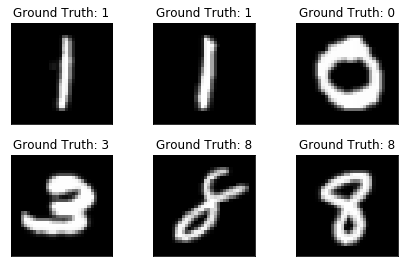

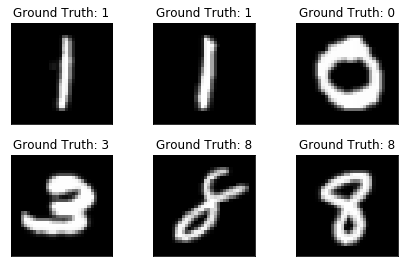

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [9]:
list(example_data[0].shape)

[1, 32, 32]

In [11]:
img_size = list(example_data[0].shape) # mnist image
# h_size = 256
z_size = 12
model = VAE(img_size, z_size).to(device) # migrates to CUDA if you can
model_old = VAE(img_size, z_size).to(device)

In [12]:
model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (mu_logvar_gen): Linear(in_features=256, out_features=24, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [15]:
# trainer = Trainer(model)

In [16]:
# %%time
# trainer(train_loader, test_loader)

In [17]:
# torch.save(model.state_dict(), './model/betaVAE.pt')

In [18]:
# older model
# model.load_state_dict(torch.load('./model/betaVAE.pt'))

<All keys matched successfully>

In [22]:
# siamese tweeked model
model.load_state_dict(torch.load('./model/Siamese/G/G-200.pt'))
# old model
model_old.load_state_dict(torch.load('./model/betaVAE.pt'))

<All keys matched successfully>

In [23]:
from torch.optim.lr_scheduler import StepLR
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [24]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         data_hat,_,_ = vae_model(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [25]:
def test(model, vae_model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data_hat,_,_ = vae_model(data)
            output = model(data_hat)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [26]:
test_batch_size = 1000
batch_size = 64
epochs = 2
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 1000
save_model = True
use_cuda = True
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [27]:
model_classification = Net().to(device)
optimizer = optim.Adadelta(model_classification.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [95]:
for epoch in range(1, epochs + 1):
    train(model_classification, device, train_loader, optimizer, epoch)
    test(model_classification, model, device, test_loader)
    test(model_classification, model_old, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.084794

Test set: Average loss: 1.9122, Accuracy: 7560/10000 (76%)


Test set: Average loss: 0.1544, Accuracy: 9589/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095666

Test set: Average loss: 1.9334, Accuracy: 7530/10000 (75%)


Test set: Average loss: 0.1548, Accuracy: 9591/10000 (96%)



([], <a list of 0 Text yticklabel objects>)

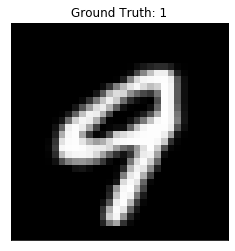

In [60]:
plt.imshow(example_data[10][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[0]))
plt.xticks([])
plt.yticks([])

In [88]:
(example_targets == 6).nonzero().data

tensor([[15],
        [25],
        [34],
        [38],
        [39],
        [42],
        [44],
        [53]])

(-0.5, 31.5, 31.5, -0.5)

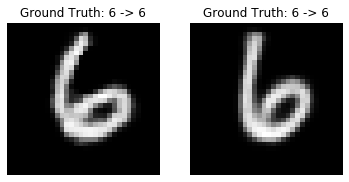

In [93]:
i = 34
recon_img,_,_ = model(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
recon_img_old,_,_ = model_old(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
plt.subplot(1,2,1)
plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
plt.title("Ground Truth: {} -> {}".format(example_targets[i], torch.argmax(model_classification(recon_img)).item()))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(recon_img_old[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
plt.title("Ground Truth: {} -> {}".format(example_targets[i], torch.argmax(model_classification(recon_img_old)).item()))
plt.axis('off')

In [25]:
class SiameseDiscriminator(nn.Module):
    def __init__(self, image_size):
        super(SiameseDiscriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),

            nn.Conv2d(4, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.Conv2d(8, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8 * 26 * 26, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 15)
        )
    
    def forward_once(self, x):
        """Define the computation performed at every call by one side of siamese network."""
#         x = x_.unsqueeze(0)
#         print(x.shape)
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        """Define the computation performed at every call."""
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [26]:
class SiameseLoss(nn.Module):
    def __init__(self, margin):
        super(Loss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)
    
    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [27]:
class DistanceBasedLoss(nn.Module):
    """
    Distance based loss function.
    For reference see:
    Hadsell et al., CVPR'06
    Chopra et al., CVPR'05
    Vo and Hays, ECCV'16
    """

    def __init__(self, margin):
        """Set parameters of distance-based loss function."""
        super(DistanceBasedLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [28]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin):
        """Set parameters of contrastive loss function."""
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        clamped = torch.clamp(self.margin - euclidean_distance, min=0.0)
        similar_loss = (1 - label) * 0.5 * torch.pow(euclidean_distance, 2)
        dissimilar_loss = label * 0.5 * torch.pow(clamped, 2)
        contrastive_loss = similar_loss + dissimilar_loss

        return torch.mean(contrastive_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [29]:
from math import exp


def gaussian(window_size, sigma):
    """Compute gaussian window, that is a tensor with values of the bell curve."""
    gauss = torch.Tensor(
        [exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel):
    """Generate a two dimensional window with desired number of channels."""
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    """Compute the structural similarity index between two images."""
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1) *
                                                    (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(nn.Module):
    """Wrapper class used to compute the structural similarity index."""

    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        """Execute the computation of the structural similarity index."""
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

In [30]:
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler


class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.targets
            self.train_data = self.mnist_dataset.data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.targets
            self.test_data = self.mnist_dataset.data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return torch.FloatTensor([target]), img1, img2

    def __len__(self):
        return len(self.mnist_dataset)

In [31]:
mnist_siamese_dataset = SiameseMNIST(mnist_dataset)
mnist_siamese_dataset_test = SiameseMNIST(mnist_dataset_test)

In [32]:
class Config:
    def __init__(self, image_size=32, mode='train', model_path='./model/Siamese', 
                 generate_path='./Generated', num_epochs=100, distance_weight=1.0, 
                 dataset='MNIST', tensorboard=True, generator=model, batch_size=64, batch_size_test=1000):
        self.mode = mode
        self.image_size = image_size
        self.model_path = model_path
        self.generate_path = generate_path
        self.dataset = dataset
        self.num_epochs = num_epochs
        self.distance_weight = distance_weight
        self.tensorboard = tensorboard
        self.generator = generator
        self.batch_size = batch_size
        self.batch_size_test = batch_size_test

In [33]:
from tqdm import tqdm
class SiameseGanSolver(object):
    """Solving GAN-like neural network with siamese discriminator."""

    def __init__(self, config, data_loader):
        """Set parameters of neural network and its training."""
        self.ssim_loss = SSIM()
        self.generator = config.generator
        self.discriminator = None
        self.distance_based_loss = None

        self.g_optimizer = None
        self.d_optimizer = None

        self.g_conv_dim = 128

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 0.0001
        self.image_size = config.image_size
        self.num_epochs = config.num_epochs
        self.distance_weight = config.distance_weight

        self.data_loader = data_loader
#         print(self.data_loader.dataset)
        self.generate_path = config.generate_path
        self.model_path = config.model_path
        self.tensorboard = config.tensorboard

        if self.tensorboard:
            self.tb_writer = tensorboardX.SummaryWriter(
                filename_suffix='_%s_%s' % (config.distance_weight, config.dataset))
            self.tb_graph_added = False

        self.build_model()

    def build_model(self):
        """Build generator and discriminator."""
#         self.generator = Generator(self.g_conv_dim, noise=self.noise, residual=self.residual)
        self.discriminator = SiameseDiscriminator(self.image_size)
        self.distance_based_loss = DistanceBasedLoss(2.0)

        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(), self.learning_rate, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), self.learning_rate, [self.beta1, self.beta2])

        if torch.cuda.is_available():
            self.generator.cuda()
            self.discriminator.cuda()
            self.distance_based_loss.cuda()

    def train(self):
        """Train generator and discriminator in minimax game."""
        # Prepare tensorboard writer
        if self.tensorboard:
            step = 0
        
        print("We are training\n")

        for epoch in tqdm(range(self.num_epochs)):
            print(str(epoch) + " " + str(datetime.now()))
#             i = 0
            for label, images0, images1 in self.data_loader:
#                 i += 1
#                 print(i)
                images0 = to_variable(images0)
                images1 = to_variable(images1)
#                 print("label:", label)
                label = to_variable(label)
#                 print("We extracted samples")
                # Train discriminator to recognize identity of real images
                output0, output1 = self.discriminator(images0, images1)
                d_real_loss = self.distance_based_loss(output0, output1, label)
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                d_real_loss.backward()
                self.d_optimizer.step()
#                 print("We did backprop")
                # Train discriminator to recognize identity of fake(privatized) images
                
                privatized_imgs, _, _ = self.generator(images0)
#                 print(privatized_imgs)
                output0, output1 = self.discriminator(images0, privatized_imgs)

                # Discriminator wants to minimize Euclidean distance between
                # original & privatized versions, hence label = 0
                d_fake_loss = self.distance_based_loss(output0, output1, 0)
                distance = 1.0 - self.ssim_loss(privatized_imgs, images0)
                d_fake_loss += self.distance_weight * distance
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                d_fake_loss.backward()
                self.d_optimizer.step()

                # Train generator to fool discriminator
                # Generator wants to push the distance between original & privatized
                # right to the margin, hence label = 1
                privatized_imgs, _, _ = self.generator(images0)
                output0, output1 = self.discriminator(images0, privatized_imgs)
                g_loss = self.distance_based_loss(output0, output1, 1)
                distance = 1.0 - self.ssim_loss(privatized_imgs, images0)
                g_loss += self.distance_weight * distance
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()

                # Write losses to tensorboard
                if self.tensorboard:
                    self.tb_writer.add_scalar('phase0/discriminator_real_loss',
                                              d_real_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/discriminator_fake_loss',
                                              d_fake_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/generator_loss',
                                              g_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/distance_loss',
                                              distance.item(), step)

                    step += 1

            # Monitor training after each epoch
            if self.tensorboard:
                self._monitor_phase_0(self.tb_writer, step)

            # At the end save generator and discriminator to files
            if (epoch + 1) % 10 == 0:
                g_path = os.path.join(self.model_path, 'G', 'G-%d.pt' % (epoch+1))
                torch.save(self.generator.state_dict(), g_path)
                d_path = os.path.join(self.model_path, 'D', 'D-%d.pt' % (epoch+1))
                torch.save(self.discriminator.state_dict(), d_path)

        if self.tensorboard:
            self.tb_writer.close()

    def _monitor_phase_0(self, writer, step, n_images=10):
        # Measure accuracy of identity verification by discriminator
        correct_pairs = 0
        total_pairs = 0

        for label, images0, images1 in self.data_loader:
            images0 = to_variable(images0)
            images1 = to_variable(images1)
            label = to_variable(label)

            # Predict label = 1 if outputs are dissimilar (distance > margin)
            privatized_images0, _, _ = self.generator(images0)
            output0, output1 = self.discriminator(privatized_images0, images1)
            predictions = self.distance_based_loss.predict(output0, output1)
            predictions = predictions.type(label.data.type())

            correct_pairs += (predictions == label).sum().item()
            total_pairs += len(predictions == label)

            if total_pairs > 1000:
                break

        # Write accuracy to tensorboard
        accuracy = correct_pairs / total_pairs
        writer.add_scalar('phase0/discriminator_accuracy', accuracy, step)

        # Generate previews of privatized images
        reals, fakes = [], []
        for _, image, _ in self.data_loader.dataset:
#             print("i: ", image.shape)
            g_image, _, _ = self.generator(to_variable(image).unsqueeze(0))
            g_image = g_image.squeeze(0)
#             print("g: ", g_image.shape)
            reals.append(denorm(to_variable(image).data[0]))
            fakes.append(denorm(to_variable(g_image).data[0]))
            if len(reals) == n_images:
                break

        # Write images to tensorboard
        real_previews = torchvision.utils.make_grid(reals, nrow=n_images)
        fake_previews = torchvision.utils.make_grid(fakes, nrow=n_images)
#         print(real_previews.shape)
#         print(fake_previews.shape)
#         img = torchvision.utils.make_grid([real_previews, fake_previews], nrow=1)
        img = torchvision.utils.make_grid(torch.stack(
            [*real_previews.unsqueeze_(1).unbind(0), *fake_previews.unsqueeze_(1).unbind(0)]), nrow=1)
        writer.add_image('Previews', img, step)

    def generate(self):
        """Generate privatized images."""
        # Load trained parameters (generator)
        g_path = os.path.join(self.model_path, 'G', 'G-%d.pkl' % self.num_epochs)
        self.generator.load_state_dict(torch.load(g_path))
        self.generator.eval()

        # Generate the images
        for relative_path, image in self.data_loader:
            fake_image, _, _ = self.generator(to_variable(image))
            fake_path = os.path.join(self.generate_path, relative_path[0])
            if not os.path.exists(os.path.dirname(fake_path)):
                os.makedirs(os.path.dirname(fake_path))
            torchvision.utils.save_image(fake_image.data, fake_path, nrow=1)

    def check_discriminator_accuracy(self):
        """Measure discriminator's accuracy."""
        # Measure accuracy of identity verification by discriminator
        correct_pairs = 0
        total_pairs = 0

        g_path = os.path.join(self.model_path, 'G', 'G-%d.pkl' % self.num_epochs)
        self.generator.load_state_dict(torch.load(g_path))
        self.generator.eval()

        d_path = os.path.join(self.model_path, 'D', 'D-%d.pkl' % self.num_epochs)
        self.discriminator.load_state_dict(torch.load(d_path))
        self.discriminator.eval()

        for label, images0, images1 in self.data_loader:
            images0 = to_variable(images0)
            images1 = to_variable(images1)
            label = to_variable(label)

            # Predict label = 1 if outputs are dissimilar (distance > margin)
            privatized_images0, _, _ = self.generator(images0)
            output0, output1 = self.discriminator(privatized_images0, images1)
            predictions = self.distance_based_loss.predict(output0, output1)
            predictions = predictions.type(label.data.type())

            correct_pairs += (predictions == label).sum().item()
            total_pairs += len(predictions)

        accuracy = correct_pairs / total_pairs
        print('distance weight = %f' % self.distance_weight)
        print('accuracy = %f' % accuracy)
        
def to_variable(tensor):
    """Convert tensor to variable."""
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

def denorm(image):
    """Convert image range (-1, 1) to (0, 1)."""
    out = (image + 1) / 2
    return out.clamp(0, 1)

In [34]:
from datetime import datetime, time
import tensorboardX, math, os
from torch.utils.data import DataLoader
config = Config(num_epochs=200, tensorboard=True)
siamese_data_loader = DataLoader(dataset=mnist_siamese_dataset, batch_size=config.batch_size, shuffle=True)
siamese_data_loader_test = DataLoader(dataset=mnist_siamese_dataset_test, batch_size=config.batch_size_test, shuffle=True)
solver = SiameseGanSolver(config, siamese_data_loader)
date1 = datetime.now()

In [35]:
# %%time
solver.train()

  0%|          | 0/200 [00:00<?, ?it/s]

We are training

0 2020-01-08 01:44:04.899575


  0%|          | 1/200 [00:33<1:51:38, 33.66s/it]

1 2020-01-08 01:44:38.560524


  1%|          | 2/200 [01:06<1:50:05, 33.36s/it]

2 2020-01-08 01:45:11.221317


  2%|▏         | 3/200 [01:39<1:49:04, 33.22s/it]

3 2020-01-08 01:45:44.111432


  2%|▏         | 4/200 [02:12<1:48:07, 33.10s/it]

4 2020-01-08 01:46:16.936330


  2%|▎         | 5/200 [02:45<1:47:35, 33.10s/it]

5 2020-01-08 01:46:50.042478


  3%|▎         | 6/200 [03:18<1:46:47, 33.03s/it]

6 2020-01-08 01:47:22.901138


  4%|▎         | 7/200 [03:51<1:46:14, 33.03s/it]

7 2020-01-08 01:47:55.935386


  4%|▍         | 8/200 [04:24<1:45:47, 33.06s/it]

8 2020-01-08 01:48:29.066377


  4%|▍         | 9/200 [04:57<1:45:04, 33.01s/it]

9 2020-01-08 01:49:01.956709


  5%|▌         | 10/200 [05:30<1:44:32, 33.01s/it]

10 2020-01-08 01:49:34.971979


  6%|▌         | 11/200 [06:02<1:43:43, 32.93s/it]

11 2020-01-08 01:50:07.711168


  6%|▌         | 12/200 [06:35<1:43:07, 32.91s/it]

12 2020-01-08 01:50:40.579261


  6%|▋         | 13/200 [07:08<1:42:38, 32.93s/it]

13 2020-01-08 01:51:13.569443


  7%|▋         | 14/200 [07:41<1:42:12, 32.97s/it]

14 2020-01-08 01:51:46.626990


  8%|▊         | 15/200 [08:14<1:41:48, 33.02s/it]

15 2020-01-08 01:52:19.747666


  8%|▊         | 16/200 [08:47<1:41:10, 32.99s/it]

16 2020-01-08 01:52:52.688507


  8%|▊         | 17/200 [09:20<1:40:31, 32.96s/it]

17 2020-01-08 01:53:25.571720


  9%|▉         | 18/200 [09:53<1:40:04, 32.99s/it]

18 2020-01-08 01:53:58.643569


 10%|▉         | 19/200 [10:26<1:39:40, 33.04s/it]

19 2020-01-08 01:54:31.786962


 10%|█         | 20/200 [10:59<1:39:00, 33.00s/it]

20 2020-01-08 01:55:04.705307


 10%|█         | 21/200 [11:32<1:38:24, 32.99s/it]

21 2020-01-08 01:55:37.660721


 11%|█         | 22/200 [12:05<1:37:40, 32.93s/it]

22 2020-01-08 01:56:10.438154


 12%|█▏        | 23/200 [12:38<1:37:13, 32.96s/it]

23 2020-01-08 01:56:43.479663


 12%|█▏        | 24/200 [13:11<1:36:42, 32.97s/it]

24 2020-01-08 01:57:16.471608


 12%|█▎        | 25/200 [13:44<1:36:07, 32.96s/it]

25 2020-01-08 01:57:49.394318


 13%|█▎        | 26/200 [14:17<1:35:32, 32.95s/it]

26 2020-01-08 01:58:22.317230


 14%|█▎        | 27/200 [14:50<1:35:12, 33.02s/it]

27 2020-01-08 01:58:55.511346


 14%|█▍        | 28/200 [15:23<1:34:29, 32.96s/it]

28 2020-01-08 01:59:28.340799


 14%|█▍        | 29/200 [15:56<1:33:52, 32.94s/it]

29 2020-01-08 02:00:01.229470


 15%|█▌        | 30/200 [16:29<1:33:16, 32.92s/it]

30 2020-01-08 02:00:34.110291


 16%|█▌        | 31/200 [17:02<1:32:44, 32.92s/it]

31 2020-01-08 02:01:07.038482


 16%|█▌        | 32/200 [17:35<1:32:14, 32.94s/it]

32 2020-01-08 02:01:40.025042


 16%|█▋        | 33/200 [18:08<1:31:44, 32.96s/it]

33 2020-01-08 02:02:13.025186


 17%|█▋        | 34/200 [18:41<1:31:12, 32.97s/it]

34 2020-01-08 02:02:46.006875


 18%|█▊        | 35/200 [19:14<1:30:37, 32.96s/it]

35 2020-01-08 02:03:18.942217


 18%|█▊        | 36/200 [19:47<1:30:07, 32.97s/it]

36 2020-01-08 02:03:51.941646


 18%|█▊        | 37/200 [20:20<1:30:14, 33.22s/it]

37 2020-01-08 02:04:25.742217


 19%|█▉        | 38/200 [20:54<1:29:46, 33.25s/it]

38 2020-01-08 02:04:59.071379


 20%|█▉        | 39/200 [21:27<1:28:55, 33.14s/it]

39 2020-01-08 02:05:31.951310


 20%|██        | 40/200 [21:59<1:28:08, 33.06s/it]

40 2020-01-08 02:06:04.808875


 20%|██        | 41/200 [22:32<1:27:31, 33.03s/it]

41 2020-01-08 02:06:37.771456


 21%|██        | 42/200 [23:05<1:26:49, 32.97s/it]

42 2020-01-08 02:07:10.605725


 22%|██▏       | 43/200 [23:38<1:26:14, 32.96s/it]

43 2020-01-08 02:07:43.541911


 22%|██▏       | 44/200 [24:11<1:25:38, 32.94s/it]

44 2020-01-08 02:08:16.440746


 22%|██▎       | 45/200 [24:44<1:25:08, 32.96s/it]

45 2020-01-08 02:08:49.445433


 23%|██▎       | 46/200 [25:17<1:24:41, 33.00s/it]

46 2020-01-08 02:09:22.536467


 24%|██▎       | 47/200 [25:50<1:24:11, 33.02s/it]

47 2020-01-08 02:09:55.597640


 24%|██▍       | 48/200 [26:23<1:23:44, 33.05s/it]

48 2020-01-08 02:10:28.730750


 24%|██▍       | 49/200 [26:56<1:23:07, 33.03s/it]

49 2020-01-08 02:11:01.700073


 25%|██▌       | 50/200 [27:29<1:22:41, 33.08s/it]

50 2020-01-08 02:11:34.885616


 26%|██▌       | 51/200 [28:02<1:21:57, 33.00s/it]

51 2020-01-08 02:12:07.722990


 26%|██▌       | 52/200 [28:35<1:21:19, 32.97s/it]

52 2020-01-08 02:12:40.616298


 26%|██▋       | 53/200 [29:08<1:20:50, 33.00s/it]

53 2020-01-08 02:13:13.680602


 27%|██▋       | 54/200 [29:41<1:20:19, 33.01s/it]

54 2020-01-08 02:13:46.729399


 28%|██▊       | 55/200 [30:14<1:19:37, 32.95s/it]

55 2020-01-08 02:14:19.521385


 28%|██▊       | 56/200 [30:47<1:19:15, 33.03s/it]

56 2020-01-08 02:14:52.729519


 28%|██▊       | 57/200 [31:20<1:18:37, 32.99s/it]

57 2020-01-08 02:15:25.636449


 29%|██▉       | 58/200 [31:53<1:18:14, 33.06s/it]

58 2020-01-08 02:15:58.854019


 30%|██▉       | 59/200 [32:26<1:17:39, 33.05s/it]

59 2020-01-08 02:16:31.878979


 30%|███       | 60/200 [32:59<1:17:03, 33.02s/it]

60 2020-01-08 02:17:04.839160


 30%|███       | 61/200 [33:33<1:16:37, 33.07s/it]

61 2020-01-08 02:17:38.033546


 31%|███       | 62/200 [34:06<1:15:55, 33.01s/it]

62 2020-01-08 02:18:10.906724


 32%|███▏      | 63/200 [34:38<1:15:20, 32.99s/it]

63 2020-01-08 02:18:43.853739


 32%|███▏      | 64/200 [35:11<1:14:45, 32.98s/it]

64 2020-01-08 02:19:16.797828


 32%|███▎      | 65/200 [35:44<1:14:13, 32.99s/it]

65 2020-01-08 02:19:49.798867


 33%|███▎      | 66/200 [36:18<1:13:45, 33.02s/it]

66 2020-01-08 02:20:22.911608


 34%|███▎      | 67/200 [36:50<1:13:10, 33.01s/it]

67 2020-01-08 02:20:55.890708


 34%|███▍      | 68/200 [37:24<1:12:39, 33.03s/it]

68 2020-01-08 02:21:28.961909


 34%|███▍      | 69/200 [37:57<1:12:05, 33.02s/it]

69 2020-01-08 02:22:01.965210


 35%|███▌      | 70/200 [38:29<1:11:27, 32.98s/it]

70 2020-01-08 02:22:34.859040


 36%|███▌      | 71/200 [39:02<1:10:48, 32.93s/it]

71 2020-01-08 02:23:07.667341


 36%|███▌      | 72/200 [39:35<1:10:07, 32.87s/it]

72 2020-01-08 02:23:40.400964


 36%|███▋      | 73/200 [40:08<1:09:30, 32.84s/it]

73 2020-01-08 02:24:13.166686


 37%|███▋      | 74/200 [40:41<1:09:07, 32.92s/it]

74 2020-01-08 02:24:46.272445


 38%|███▊      | 75/200 [41:14<1:08:29, 32.87s/it]

75 2020-01-08 02:25:19.039867


 38%|███▊      | 76/200 [41:47<1:08:02, 32.93s/it]

76 2020-01-08 02:25:52.086580


 38%|███▊      | 77/200 [42:19<1:07:23, 32.88s/it]

77 2020-01-08 02:26:24.845551


 39%|███▉      | 78/200 [42:52<1:06:49, 32.87s/it]

78 2020-01-08 02:26:57.685959


 40%|███▉      | 79/200 [43:25<1:06:21, 32.91s/it]

79 2020-01-08 02:27:30.697898


 40%|████      | 80/200 [43:58<1:05:50, 32.92s/it]

80 2020-01-08 02:28:03.634666


 40%|████      | 81/200 [44:31<1:05:24, 32.98s/it]

81 2020-01-08 02:28:36.756096


 41%|████      | 82/200 [45:04<1:04:55, 33.01s/it]

82 2020-01-08 02:29:09.843776


 42%|████▏     | 83/200 [45:38<1:04:24, 33.03s/it]

83 2020-01-08 02:29:42.903604


 42%|████▏     | 84/200 [46:11<1:03:52, 33.04s/it]

84 2020-01-08 02:30:15.976379


 42%|████▎     | 85/200 [46:43<1:03:15, 33.00s/it]

85 2020-01-08 02:30:48.887460


 43%|████▎     | 86/200 [47:17<1:02:45, 33.03s/it]

86 2020-01-08 02:31:21.972244


 44%|████▎     | 87/200 [47:49<1:02:04, 32.96s/it]

87 2020-01-08 02:31:54.786710


 44%|████▍     | 88/200 [48:23<1:01:44, 33.08s/it]

88 2020-01-08 02:32:28.134304


 44%|████▍     | 89/200 [48:56<1:01:11, 33.07s/it]

89 2020-01-08 02:33:01.198906


 45%|████▌     | 90/200 [49:29<1:00:35, 33.05s/it]

90 2020-01-08 02:33:34.183401


 46%|████▌     | 91/200 [50:02<59:57, 33.00s/it]  

91 2020-01-08 02:34:07.087283


 46%|████▌     | 92/200 [50:35<59:21, 32.97s/it]

92 2020-01-08 02:34:39.985643


 46%|████▋     | 93/200 [51:07<58:39, 32.89s/it]

93 2020-01-08 02:35:12.696877


 47%|████▋     | 94/200 [51:40<58:04, 32.87s/it]

94 2020-01-08 02:35:45.525819


 48%|████▊     | 95/200 [52:13<57:39, 32.95s/it]

95 2020-01-08 02:36:18.655764


 48%|████▊     | 96/200 [52:46<57:13, 33.02s/it]

96 2020-01-08 02:36:51.833094


 48%|████▊     | 97/200 [53:20<56:43, 33.04s/it]

97 2020-01-08 02:37:24.927463


 49%|████▉     | 98/200 [53:53<56:13, 33.07s/it]

98 2020-01-08 02:37:58.065073


 50%|████▉     | 99/200 [54:26<55:34, 33.02s/it]

99 2020-01-08 02:38:30.959219


 50%|█████     | 100/200 [54:58<54:57, 32.97s/it]

100 2020-01-08 02:39:03.825927


 50%|█████     | 101/200 [55:31<54:22, 32.96s/it]

101 2020-01-08 02:39:36.740851


 51%|█████     | 102/200 [56:04<53:47, 32.94s/it]

102 2020-01-08 02:40:09.639718


 52%|█████▏    | 103/200 [56:37<53:12, 32.92s/it]

103 2020-01-08 02:40:42.503158


 52%|█████▏    | 104/200 [57:10<52:41, 32.94s/it]

104 2020-01-08 02:41:15.484275


 52%|█████▎    | 105/200 [57:43<52:13, 32.98s/it]

105 2020-01-08 02:41:48.584191


 53%|█████▎    | 106/200 [58:16<51:42, 33.00s/it]

106 2020-01-08 02:42:21.629806


 54%|█████▎    | 107/200 [58:49<51:04, 32.95s/it]

107 2020-01-08 02:42:54.451663


 54%|█████▍    | 108/200 [59:22<50:27, 32.91s/it]

108 2020-01-08 02:43:27.275413


 55%|█████▍    | 109/200 [59:55<49:54, 32.91s/it]

109 2020-01-08 02:44:00.178297


 55%|█████▌    | 110/200 [1:00:28<49:26, 32.96s/it]

110 2020-01-08 02:44:33.253960


 56%|█████▌    | 111/200 [1:01:01<48:48, 32.91s/it]

111 2020-01-08 02:45:06.046824


 56%|█████▌    | 112/200 [1:01:34<48:19, 32.95s/it]

112 2020-01-08 02:45:39.077641


 56%|█████▋    | 113/200 [1:02:07<47:46, 32.95s/it]

113 2020-01-08 02:46:12.046001


 57%|█████▋    | 114/200 [1:02:40<47:15, 32.97s/it]

114 2020-01-08 02:46:45.051098


 57%|█████▊    | 115/200 [1:03:13<46:39, 32.94s/it]

115 2020-01-08 02:47:17.921720


 58%|█████▊    | 116/200 [1:03:46<46:11, 33.00s/it]

116 2020-01-08 02:47:51.058226


 58%|█████▊    | 117/200 [1:04:18<45:33, 32.93s/it]

117 2020-01-08 02:48:23.836901


 59%|█████▉    | 118/200 [1:04:51<45:02, 32.96s/it]

118 2020-01-08 02:48:56.850938


 60%|█████▉    | 119/200 [1:05:25<44:33, 33.01s/it]

119 2020-01-08 02:49:29.970278


 60%|██████    | 120/200 [1:05:57<43:57, 32.97s/it]

120 2020-01-08 02:50:02.857625


 60%|██████    | 121/200 [1:06:31<43:28, 33.02s/it]

121 2020-01-08 02:50:36.008361


 61%|██████    | 122/200 [1:07:04<42:56, 33.03s/it]

122 2020-01-08 02:51:09.041908


 62%|██████▏   | 123/200 [1:07:37<42:22, 33.01s/it]

123 2020-01-08 02:51:42.025319


 62%|██████▏   | 124/200 [1:08:10<41:46, 32.99s/it]

124 2020-01-08 02:52:14.943538


 62%|██████▎   | 125/200 [1:08:43<41:16, 33.02s/it]

125 2020-01-08 02:52:48.036175


 63%|██████▎   | 126/200 [1:09:15<40:39, 32.96s/it]

126 2020-01-08 02:53:20.869772


 64%|██████▎   | 127/200 [1:09:48<40:02, 32.91s/it]

127 2020-01-08 02:53:53.653790


 64%|██████▍   | 128/200 [1:10:21<39:30, 32.92s/it]

128 2020-01-08 02:54:26.588988


 64%|██████▍   | 129/200 [1:10:54<38:58, 32.94s/it]

129 2020-01-08 02:54:59.593461


 65%|██████▌   | 130/200 [1:11:27<38:24, 32.92s/it]

130 2020-01-08 02:55:32.444685


 66%|██████▌   | 131/200 [1:12:00<37:53, 32.94s/it]

131 2020-01-08 02:56:05.458295


 66%|██████▌   | 132/200 [1:12:33<37:20, 32.94s/it]

132 2020-01-08 02:56:38.393528


 66%|██████▋   | 133/200 [1:13:06<36:47, 32.95s/it]

133 2020-01-08 02:57:11.348483


 67%|██████▋   | 134/200 [1:13:39<36:15, 32.97s/it]

134 2020-01-08 02:57:44.368676


 68%|██████▊   | 135/200 [1:14:12<35:42, 32.97s/it]

135 2020-01-08 02:58:17.327096


 68%|██████▊   | 136/200 [1:14:45<35:10, 32.98s/it]

136 2020-01-08 02:58:50.353192


 68%|██████▊   | 137/200 [1:15:18<34:39, 33.01s/it]

137 2020-01-08 02:59:23.435848


 69%|██████▉   | 138/200 [1:15:51<34:11, 33.09s/it]

138 2020-01-08 02:59:56.706643


 70%|██████▉   | 139/200 [1:16:24<33:34, 33.03s/it]

139 2020-01-08 03:00:29.582830


 70%|███████   | 140/200 [1:16:57<33:01, 33.03s/it]

140 2020-01-08 03:01:02.614676


 70%|███████   | 141/200 [1:17:30<32:29, 33.04s/it]

141 2020-01-08 03:01:35.684263


 71%|███████   | 142/200 [1:18:03<31:53, 33.00s/it]

142 2020-01-08 03:02:08.576745


 72%|███████▏  | 143/200 [1:18:36<31:21, 33.01s/it]

143 2020-01-08 03:02:41.635631


 72%|███████▏  | 144/200 [1:19:09<30:45, 32.96s/it]

144 2020-01-08 03:03:14.473282


 72%|███████▎  | 145/200 [1:19:42<30:14, 32.99s/it]

145 2020-01-08 03:03:47.528872


 73%|███████▎  | 146/200 [1:20:15<29:39, 32.96s/it]

146 2020-01-08 03:04:20.407484


 74%|███████▎  | 147/200 [1:20:48<29:07, 32.97s/it]

147 2020-01-08 03:04:53.401991


 74%|███████▍  | 148/200 [1:21:21<28:35, 32.99s/it]

148 2020-01-08 03:05:26.454577


 74%|███████▍  | 149/200 [1:21:54<28:04, 33.03s/it]

149 2020-01-08 03:05:59.583645


 75%|███████▌  | 150/200 [1:22:27<27:33, 33.07s/it]

150 2020-01-08 03:06:32.750563


 76%|███████▌  | 151/200 [1:23:00<26:59, 33.05s/it]

151 2020-01-08 03:07:05.731338


 76%|███████▌  | 152/200 [1:23:33<26:23, 32.99s/it]

152 2020-01-08 03:07:38.592296


 76%|███████▋  | 153/200 [1:24:06<25:48, 32.95s/it]

153 2020-01-08 03:08:11.450399


 77%|███████▋  | 154/200 [1:24:39<25:17, 32.99s/it]

154 2020-01-08 03:08:44.545019


 78%|███████▊  | 155/200 [1:25:12<24:44, 32.98s/it]

155 2020-01-08 03:09:17.490521


 78%|███████▊  | 156/200 [1:25:45<24:12, 33.00s/it]

156 2020-01-08 03:09:50.549283


 78%|███████▊  | 157/200 [1:26:18<23:40, 33.04s/it]

157 2020-01-08 03:10:23.662962


 79%|███████▉  | 158/200 [1:26:51<23:04, 32.98s/it]

158 2020-01-08 03:10:56.495261


 80%|███████▉  | 159/200 [1:27:24<22:34, 33.03s/it]

159 2020-01-08 03:11:29.648953


 80%|████████  | 160/200 [1:27:57<21:58, 32.96s/it]

160 2020-01-08 03:12:02.464786


 80%|████████  | 161/200 [1:28:30<21:26, 32.97s/it]

161 2020-01-08 03:12:35.463064


 81%|████████  | 162/200 [1:29:03<20:53, 32.99s/it]

162 2020-01-08 03:13:08.502575


 82%|████████▏ | 163/200 [1:29:36<20:19, 32.95s/it]

163 2020-01-08 03:13:41.350913


 82%|████████▏ | 164/200 [1:30:09<19:44, 32.91s/it]

164 2020-01-08 03:14:14.177903


 82%|████████▎ | 165/200 [1:30:42<19:12, 32.94s/it]

165 2020-01-08 03:14:47.184337


 83%|████████▎ | 166/200 [1:31:15<18:39, 32.92s/it]

166 2020-01-08 03:15:20.070448


 84%|████████▎ | 167/200 [1:31:48<18:09, 33.02s/it]

167 2020-01-08 03:15:53.309940


 84%|████████▍ | 168/200 [1:32:21<17:37, 33.05s/it]

168 2020-01-08 03:16:26.416096


 84%|████████▍ | 169/200 [1:32:54<17:04, 33.06s/it]

169 2020-01-08 03:16:59.501225


 85%|████████▌ | 170/200 [1:33:27<16:32, 33.07s/it]

170 2020-01-08 03:17:32.596001


 86%|████████▌ | 171/200 [1:34:00<15:58, 33.05s/it]

171 2020-01-08 03:18:05.603810


 86%|████████▌ | 172/200 [1:34:33<15:25, 33.04s/it]

172 2020-01-08 03:18:38.613430


 86%|████████▋ | 173/200 [1:35:06<14:50, 32.99s/it]

173 2020-01-08 03:19:11.485561


 87%|████████▋ | 174/200 [1:35:39<14:15, 32.92s/it]

174 2020-01-08 03:19:44.241583


 88%|████████▊ | 175/200 [1:36:12<13:43, 32.92s/it]

175 2020-01-08 03:20:17.165760


 88%|████████▊ | 176/200 [1:36:45<13:10, 32.96s/it]

176 2020-01-08 03:20:50.211083


 88%|████████▊ | 177/200 [1:37:18<12:38, 32.98s/it]

177 2020-01-08 03:21:23.228233


 89%|████████▉ | 178/200 [1:37:51<12:04, 32.95s/it]

178 2020-01-08 03:21:56.116291


 90%|████████▉ | 179/200 [1:38:24<11:32, 32.97s/it]

179 2020-01-08 03:22:29.133712


 90%|█████████ | 180/200 [1:38:57<10:59, 32.98s/it]

180 2020-01-08 03:23:02.142103


 90%|█████████ | 181/200 [1:39:30<10:26, 32.96s/it]

181 2020-01-08 03:23:35.055152


 91%|█████████ | 182/200 [1:40:03<09:54, 33.02s/it]

182 2020-01-08 03:24:08.219678


 92%|█████████▏| 183/200 [1:40:36<09:20, 32.97s/it]

183 2020-01-08 03:24:41.075341


 92%|█████████▏| 184/200 [1:41:09<08:47, 32.95s/it]

184 2020-01-08 03:25:13.965233


 92%|█████████▎| 185/200 [1:41:42<08:14, 32.96s/it]

185 2020-01-08 03:25:46.964998


 93%|█████████▎| 186/200 [1:42:14<07:40, 32.91s/it]

186 2020-01-08 03:26:19.740111


 94%|█████████▎| 187/200 [1:42:48<07:08, 32.98s/it]

187 2020-01-08 03:26:52.903909


 94%|█████████▍| 188/200 [1:43:21<06:36, 33.02s/it]

188 2020-01-08 03:27:25.992882


 94%|█████████▍| 189/200 [1:43:54<06:03, 33.05s/it]

189 2020-01-08 03:27:59.128834


 95%|█████████▌| 190/200 [1:44:27<05:30, 33.03s/it]

190 2020-01-08 03:28:32.114168


 96%|█████████▌| 191/200 [1:45:00<04:57, 33.05s/it]

191 2020-01-08 03:29:05.191473


 96%|█████████▌| 192/200 [1:45:33<04:24, 33.05s/it]

192 2020-01-08 03:29:38.252497


 96%|█████████▋| 193/200 [1:46:06<03:51, 33.07s/it]

193 2020-01-08 03:30:11.355976


 97%|█████████▋| 194/200 [1:46:39<03:18, 33.11s/it]

194 2020-01-08 03:30:44.553778


 98%|█████████▊| 195/200 [1:47:12<02:45, 33.04s/it]

195 2020-01-08 03:31:17.447486


 98%|█████████▊| 196/200 [1:47:45<02:12, 33.05s/it]

196 2020-01-08 03:31:50.500911


 98%|█████████▊| 197/200 [1:48:18<01:39, 33.06s/it]

197 2020-01-08 03:32:23.589050


 99%|█████████▉| 198/200 [1:48:51<01:06, 33.07s/it]

198 2020-01-08 03:32:56.684654


100%|█████████▉| 199/200 [1:49:24<00:33, 33.07s/it]

199 2020-01-08 03:33:29.762776


100%|██████████| 200/200 [1:49:57<00:00, 32.99s/it]

CPU times: user 1h 54min 55s, sys: 1min 40s, total: 1h 56min 36s
Wall time: 1h 49min 57s


Hi, Ujjwal. The training has been completed. It took approx 0 days, 1 hours, 49 minutes, 57 seconds
